<a href="https://colab.research.google.com/github/Parvez13/TensorFlow-Developer-Certification/blob/master/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be seqeuence text or speech).

Another common term for NLP problems is sequence to sequence problems(seq2seq).

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cf6a26dc-e3e2-8bbf-5334-53bfd808e555)


## Get helper functions


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves,  compare_historys

--2021-08-14 02:08:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-14 02:08:36 (87.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a test dataset

The dataset we're going to be using is Kaggles's introduction to NLP dataset (text samples of Tweetss labelled as disaster or not disaster)

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data('nlp_getting_started.zip')

--2021-08-14 02:08:38--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2021-08-14 02:08:38 (126 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text data

To visualize our text samples, we first have to read them in, one way to do so would be  to use Python: https://realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use pandas..

In [4]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training DataFrame
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many  examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize some ranodm training examples
import random
random_index = random.randint(0, len(train_df)-5) # Create random indexes 
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _,text, target = row
  print(f"Target': {target}", "{real_disaster}" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("----\n")

Target': 1 {real_disaster}
Text:
HWRF absolutely lashes Taipei with Hurricane force winds High Storm Surge and 20' of rain. Not good news at all!!! http://t.co/CNkvILe7bE

----

Target': 1 {real_disaster}
Text:
JAX issues Hazardous Weather Outlook (HWO)  http://t.co/u9fCb8dz3h #WX

----

Target': 1 {real_disaster}
Text:
Pakistan Supreme Court endorses military courts for terrorism cases http://t.co/sZeapuEuvy

----

Target': 0 (not real disaster)
Text:
@DevinJoslyn thunder and lighting ????

----

Target': 1 {real_disaster}
Text:
If you did a cannon ball into the ocean then Japan would evacuate.

----



### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split


In [11]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you cna build a model is to covert your text to numbers.

There are a few ways to do this, namely:
* Tokenization -direct mapping of token (a token could be a word or a character ) to a number.
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned).

### Text Vectorization(tokenization)

In [14]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing  import TextVectorization

# Use the default TextVectorization parameters
text_vectorization = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                       standardize="lower_and_strip_punctuation",
                                       split='whitespace',
                                       ngrams=None, #Create group of n-words?
                                       output_mode='int',#how to map tokens to numbers
                                       output_sequence_length=None, # how long do you wnat your sequence to be
                                       pad_to_max_tokens=True)

In [16]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be ( e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                       output_mode='int',
                                       output_sequence_length=max_length)

In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [19]:
# Create a sample sentences and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
\n\n Vectorized Version:")
text_vectorizer([random_sentence])

Original text:
 Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/2Mwc9YWjZy

 Vectorized Version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[117,   5, 526,  60, 177,  51,  76, 354, 117, 446,  18,   2, 163,
        298,   6]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab=text_vectorizer.get_vocabulary() # get all of the unique words 
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words : {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words : ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding we're going to use TensorFlow's embedding layer

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to be embedding layer

In [22]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # Set input shape
                             output_dim=128, # output shape
                             embeddings_initializer='uniform',
                             input_length=max_length # how long is each input
                             )

embedding

In [23]:
# Get a  random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
       \n\nEmbedded version: ")
# Embed the random sentence (turn it into dense vectors of fixe size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 @mockingpanems @cuddlesforjen what if he slammed her against the wall for the wrong reason but then he came out of hijack mode and it       

Embedded version: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04307126, -0.03968736, -0.04770556, ...,  0.00055731,
          0.01833303, -0.01882985],
        [ 0.04307126, -0.03968736, -0.04770556, ...,  0.00055731,
          0.01833303, -0.01882985],
        [ 0.01212876, -0.03808264,  0.04706918, ...,  0.01207372,
          0.02808715, -0.01785101],
        ...,
        [ 0.00979706,  0.03079149, -0.04056146, ..., -0.03578507,
         -0.00513768, -0.04183627],
        [-0.00123669,  0.03423302, -0.01482985, ...,  0.00021151,
         -0.0440985 , -0.04790274],
        [ 0.02904454,  0.04967893,  0.03023428, ...,  0.02800744,
         -0.01726122,  0.00196667]]], dtype=float32)>

In [24]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.04307126, -0.03968736, -0.04770556,  0.04890377,  0.04095253,
         0.01899752, -0.03904061,  0.03186799,  0.02386254,  0.02946614,
         0.00925685,  0.00243844,  0.03438065, -0.02625864,  0.03531183,
        -0.01647588,  0.01439724, -0.01046281, -0.04400965,  0.01348091,
         0.04306728,  0.03551532, -0.04876692, -0.04445463,  0.04756193,
         0.02070798,  0.03896553, -0.02381012,  0.01583183,  0.01455331,
        -0.02825388,  0.00097171, -0.03172892, -0.01568806, -0.03919877,
        -0.04505816, -0.02793038, -0.00760521, -0.00222658,  0.02045326,
        -0.03730854, -0.01498959,  0.01095133,  0.00274177, -0.02788925,
        -0.03509646, -0.01380044, -0.00055686, -0.02080159, -0.00382723,
         0.02970156, -0.00749042,  0.00115327,  0.04987929,  0.00824774,
         0.03494335,  0.03512171,  0.02280324,  0.00911069,  0.01410179,
        -0.04308701, -0.03083766, -0.04468947,  0.03822399,  0.00982056,
  

## Modelling a text dataset (running a series of experiments)

Now we've a got way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data.

How are we going to approach all of these?

Use the standard steps in modelling with tenosrflow.

* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To Create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> 🔑**NOte:** It's common practice to use non-DL algorithm as a baseline because of their speed and then later using DL, to see if you can improve upon them

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling Pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()), # Convert words to numbers using tfidf
                    ('clf', MultinomialNB()) # Model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [26]:
# Evaluata a baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achiever an accuracy of : {baseline_score*100:.2f}%")

Our baseline model achiever an accuracy of : 79.27%


In [27]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function

Let's create one tom compare our model's predictions with the truth labels using the following:
* Accuracy
* Precision
* Recall
* F1-score

In [28]:
# Function to evaluate : accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """

  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using 'weighted' average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {"accuracy" : model_accuracy,
                   "precison" : model_precision,
                   "recall"  : model_recall,
                   "f1" : model_f1}
  return model_results

In [29]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precison': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [30]:
# Create a tenorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback


# Create a directory to save TensorBaord logs
SAVE_DIR = 'model_logs'

In [31]:
# Build model with The Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensitonal string
x = text_vectorizer(inputs)  # turn the input text into numbers
x = embedding(x) # create an embedding of the numerical inputs
x = layers.GlobalAveragePooling1D()(x) # Condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation='sigmoid' )(x) # Create the output layer.
model_1 = tf.keras.Model(inputs, outputs,name='model_1_dense')

In [32]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [34]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20210814-020847
Epoch 1/5
215/215 [==============================] - 7s 17ms/step - loss: 0.6122 - accuracy: 0.6900 - val_loss: 0.5351 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4426 - accuracy: 0.8183 - val_loss: 0.4777 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3472 - accuracy: 0.8612 - val_loss: 0.4590 - val_accuracy: 0.7966
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2849 - accuracy: 0.8911 - val_loss: 0.4644 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2376 - accuracy: 0.9114 - val_loss: 0.4772 - val_accuracy: 0.7835


In [35]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4772 - accuracy: 0.7835


[0.47717681527137756, 0.7834645509719849]

In [36]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [37]:
model_1_pred_probs[0]

array([0.37800977], dtype=float32)

In [38]:
# Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.37800977],
       [0.7360887 ],
       [0.9970427 ],
       [0.12330737],
       [0.13244373],
       [0.9414641 ],
       [0.90781134],
       [0.99254864],
       [0.9589887 ],
       [0.26552477]], dtype=float32)

In [39]:
# Convert model predictions probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [40]:
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [41]:
# calculate out model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.34645669291339,
 'f1': 0.7804929895574078,
 'precison': 0.7880043492637875,
 'recall': 0.7834645669291339}

In [42]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precison': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [43]:
import numpy as np
np.array(list(model_1_results.values()))>np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned Embeddings

In [44]:
# Get the vocabulary from the text vectorization layer
words_in_vocab=text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for -5 epochs)
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector:http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves:https://www.tensorflow.org/tutorials/text/word_embeddings

In [47]:
# Create embedding files (we got this TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


In [48]:
# Download files from colab to upload to projector 
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading the files above we can visualize https://projector.tensorflow.org/ and clicking the "load" button on the left hand side

> 📝**Resources**: If you'd like to know more about embeddings
* Jay Alammar's visualized word2vec post: https://jalammar.github.io/illustrated-word2vec/
* TensorFlow's Word Embeddings guide: https://www.tensorflow.org/tutorials/text/word_embeddings.

## Recurrent Neural Networks(RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

> 📝**Resources:**If you want an overview of the internals of a recurrent neural network, see the following:
- MIT's sequence modelling lecture https://www.youtube.com/watch?v=qjrad0V0uJE&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=3

- Chris Olabh's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

- Andrei Karpathy's the unreasonable effectiveness of recurrent neural networks:http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```


In [49]:
# Crete an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1, ), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cels together, you need to return_sequences=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
# print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs,name='model_2_LSTM')

In [50]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [52]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20210814-020908
Epoch 1/5
215/215 [==============================] - 10s 21ms/step - loss: 0.2142 - accuracy: 0.9215 - val_loss: 0.5626 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1553 - accuracy: 0.9435 - val_loss: 0.6001 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1244 - accuracy: 0.9555 - val_loss: 0.6427 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1042 - accuracy: 0.9604 - val_loss: 0.7135 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0858 - accuracy: 0.9657 - val_loss: 1.0014 - val_accuracy: 0.7730


In [53]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[1.6925958e-03],
       [8.4866399e-01],
       [9.9981052e-01],
       [1.0082269e-02],
       [3.9386307e-04],
       [9.9812704e-01],
       [9.2860961e-01],
       [9.9991012e-01],
       [9.9971479e-01],
       [1.6678491e-01]], dtype=float32)

In [54]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [55]:
# Calculate model_2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)

In [56]:
model_2_results

{'accuracy': 77.29658792650919,
 'f1': 0.7673391656682903,
 'precison': 0.7844442178594743,
 'recall': 0.7729658792650919}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters

In [57]:
# Build an RNN using the GRU Cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# x = layers.GRU(64, return_sequences=True)(x) # If you want to stack recurrent layers on top of each other, you need return_sequences=true
# x = layers.LSTM(42, return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')


In [58]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [59]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [60]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20210814-020952
Epoch 1/5
215/215 [==============================] - 6s 20ms/step - loss: 0.1594 - accuracy: 0.9356 - val_loss: 0.7950 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0874 - accuracy: 0.9689 - val_loss: 0.8515 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0714 - accuracy: 0.9731 - val_loss: 0.8853 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0593 - accuracy: 0.9752 - val_loss: 1.0690 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0554 - accuracy: 0.9765 - val_loss: 1.1420 - val_accuracy: 0.7782


In [61]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[1.6389630e-03],
       [7.9922563e-01],
       [9.9986207e-01],
       [1.6708288e-01],
       [1.1924260e-04],
       [9.9977559e-01],
       [8.7433738e-01],
       [9.9995840e-01],
       [9.9988580e-01],
       [9.3235153e-01]], dtype=float32)

In [62]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [63]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)

In [64]:
model_3_results

{'accuracy': 77.82152230971128,
 'f1': 0.7766208088282468,
 'precison': 0.7791991586469295,
 'recall': 0.7782152230971129}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentences) however, a bidirectional RNN goes from right  to left as well as left to right

In [65]:
# Build a Bidirectional RNN in TensorFlow

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
# print(x.shape)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')


In [66]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Compile model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [68]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20210814-021015
Epoch 1/5
215/215 [==============================] - 7s 23ms/step - loss: 0.1076 - accuracy: 0.9635 - val_loss: 1.0256 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0484 - accuracy: 0.9781 - val_loss: 1.2798 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0447 - accuracy: 0.9793 - val_loss: 1.1682 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0426 - accuracy: 0.9804 - val_loss: 1.3694 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0404 - accuracy: 0.9800 - val_loss: 1.5051 - val_accuracy: 0.7730


In [69]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs

array([[6.83552772e-03],
       [9.95123208e-01],
       [9.99992847e-01],
       [2.38144949e-01],
       [4.52910608e-05],
       [9.99907851e-01],
       [8.83969009e-01],
       [9.99995589e-01],
       [9.99991894e-01],
       [9.97706890e-01],
       [7.63719800e-05],
       [9.97041762e-01],
       [8.86664202e-05],
       [3.60150069e-01],
       [4.94557935e-05],
       [4.51501692e-04],
       [2.89184856e-04],
       [4.51039123e-05],
       [1.19548873e-03],
       [9.99827385e-01],
       [9.96174574e-01],
       [8.58646235e-05],
       [9.99984384e-01],
       [4.01693891e-04],
       [9.99989033e-01],
       [9.99992847e-01],
       [3.22178996e-04],
       [9.01184452e-04],
       [1.20184377e-04],
       [2.90995799e-02],
       [9.95961130e-01],
       [7.24542886e-04],
       [1.62452012e-01],
       [2.69911892e-04],
       [8.85732412e-01],
       [1.75556093e-01],
       [9.99987602e-01],
       [1.48357868e-01],
       [2.49559642e-03],
       [9.99988317e-01],


In [70]:
# Convert pred probs to pred lables
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [71]:
# Calculate the results ofour bidirectional model
model_4_results  = calculate_results(y_true=val_labels,
                                     y_pred=model_4_preds)

In [72]:
model_4_results

{'accuracy': 77.29658792650919,
 'f1': 0.7710949612836401,
 'precison': 0.7742755789705,
 'recall': 0.7729658792650919}

### Convolutional Neural Network 1D

We've used CNN's for images but images are typically 2D (height x width).. however, our text data is 1D.

Previously we've Conv2D for our image data but now we're going to use Con1D.

The typical structure of  a Conv1D model for sequences (in our case, text):

```
Inputs(text) -> Tokenization - > Embedding -> Layer(s) (typically conv1D + pooling) -> Outputs( class probabilities)
```

### Model 5: Conv1D

In [73]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(['this is a test sentence']))
conv_1d = layers.Conv1D(filters=64,
                        kernel_size=5,
                        activation='relu',
                        padding='valid')
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most importand feature"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 64]), TensorShape([1, 64]))

In [74]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03293345, -0.09483284, -0.07162626, ...,  0.0335042 ,
          0.08426885, -0.01270636],
        [-0.01397536, -0.0133738 ,  0.00022219, ...,  0.01684317,
          0.03299491,  0.04701665],
        [-0.06684846, -0.0340456 , -0.09511403, ..., -0.04312361,
         -0.00301494,  0.03267962],
        ...,
        [ 0.01327355, -0.04860976, -0.01950936, ...,  0.00539449,
          0.01508729,  0.0314534 ],
        [ 0.01327355, -0.04860976, -0.01950936, ...,  0.00539449,
          0.01508729,  0.0314534 ],
        [ 0.01327355, -0.04860976, -0.01950936, ...,  0.00539449,
          0.01508729,  0.0314534 ]]], dtype=float32)>

In [75]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 64), dtype=float32, numpy=
array([[[0.06232678, 0.03391613, 0.        , 0.04408022, 0.0224288 ,
         0.04873555, 0.        , 0.04262213, 0.        , 0.0163779 ,
         0.05088923, 0.        , 0.        , 0.03806809, 0.01430319,
         0.01484025, 0.02124374, 0.        , 0.05999806, 0.        ,
         0.00801826, 0.        , 0.        , 0.        , 0.        ,
         0.01373434, 0.02035277, 0.08209611, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.03822722, 0.        ,
         0.        , 0.03331044, 0.02700141, 0.03150186, 0.12632579,
         0.02264651, 0.        , 0.04336007, 0.00705078, 0.        ,
         0.02741063, 0.07188413, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00223963, 0.        ,
         0.        , 0.04580238, 0.        , 0.07090452, 0.00113162,
         0.04523268, 0.        , 0.        , 0.02422788],
        [0.        , 0.        , 0.        , 0.        , 0.  

In [76]:
max_pool_output

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.06232678, 0.03525705, 0.0476663 , 0.04408022, 0.0224288 ,
        0.04873555, 0.        , 0.04262213, 0.00681524, 0.04270532,
        0.05088923, 0.07436691, 0.00856651, 0.0477021 , 0.05745345,
        0.05055408, 0.02998128, 0.04912412, 0.05999806, 0.01878736,
        0.01251871, 0.00052283, 0.06125479, 0.00427495, 0.        ,
        0.04627338, 0.06354433, 0.08209611, 0.05869231, 0.04199681,
        0.03651241, 0.        , 0.0189861 , 0.03822722, 0.        ,
        0.00532723, 0.03331044, 0.10977989, 0.03150186, 0.12632579,
        0.02486999, 0.04847942, 0.04336007, 0.0835389 , 0.04112861,
        0.06871966, 0.07188413, 0.03319189, 0.        , 0.05477422,
        0.01716983, 0.01693088, 0.00948318, 0.01710168, 0.02002876,
        0.0350948 , 0.04580238, 0.01729442, 0.07090452, 0.02029171,
        0.04718829, 0.03036987, 0.04926258, 0.02422788]], dtype=float32)>

In [77]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation='relu')(x)
outputs=layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_conv1D')

# compile Conv1D
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [78]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                      'Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20210814-021103
Epoch 1/5
215/215 [==============================] - 6s 19ms/step - loss: 0.1288 - accuracy: 0.9599 - val_loss: 0.9064 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0744 - accuracy: 0.9720 - val_loss: 1.0362 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0632 - accuracy: 0.9747 - val_loss: 1.1287 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0571 - accuracy: 0.9765 - val_loss: 1.2165 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0510 - accuracy: 0.9784 - val_loss: 1.2555 - val_accuracy: 0.7559


In [79]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs

array([[2.72118449e-02],
       [9.04019475e-01],
       [9.99919653e-01],
       [6.68274835e-02],
       [1.68547928e-07],
       [9.90532517e-01],
       [8.73179913e-01],
       [9.99708474e-01],
       [9.99996781e-01],
       [9.19445992e-01],
       [3.02599084e-08],
       [9.35657680e-01],
       [7.02404577e-07],
       [6.77297488e-02],
       [1.57297814e-06],
       [1.54348905e-03],
       [6.35953911e-04],
       [2.44005014e-06],
       [2.17685662e-02],
       [9.95825052e-01],
       [6.12104118e-01],
       [4.59088767e-07],
       [9.99515295e-01],
       [4.91143845e-04],
       [9.99953747e-01],
       [1.00000000e+00],
       [2.13453197e-04],
       [8.39863904e-04],
       [5.76132967e-04],
       [6.97071075e-01],
       [3.19763422e-01],
       [3.79875491e-05],
       [3.08647007e-01],
       [3.82000086e-04],
       [2.41280030e-02],
       [5.01605034e-01],
       [9.99999642e-01],
       [1.60222530e-01],
       [1.16651431e-02],
       [9.99831200e-01],


In [80]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [81]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.59055118110236,
 'f1': 0.7535524954357875,
 'precison': 0.7573698742202679,
 'recall': 0.7559055118110236}

### Model 6: TensorFlow Hub Pretrained Sentences Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [82]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680985  0.05589838 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105888  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209305  0.0267898   0.03011008  0.00321069
 -0.00337971 -0.04787356  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666384  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871508  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758105  0.03327729], shape=(50,), dtype=float32)


In [83]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157027,  0.0248591 ,  0.02878048, ..., -0.00186125,
         0.02315824, -0.01485021],
       [ 0.03485874, -0.08845595, -0.01677877, ..., -0.02750706,
         0.03230237, -0.00820087]], dtype=float32)>

In [84]:
# Create a keras layer using the USE pretrained layer from tensorflow hub

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [85]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='model_6_USE')

# compile
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [86]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210814-021145
Epoch 1/5
215/215 [==============================] - 7s 23ms/step - loss: 0.5036 - accuracy: 0.7834 - val_loss: 0.4535 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 2s 12ms/step - loss: 0.4152 - accuracy: 0.8161 - val_loss: 0.4451 - val_accuracy: 0.8031
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4023 - accuracy: 0.8206 - val_loss: 0.4349 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3939 - accuracy: 0.8270 - val_loss: 0.4333 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3867 - accuracy: 0.8283 - val_loss: 0.4289 - val_accuracy: 0.8176


In [87]:
# Make predictions with USE TF Hub Model
model_6_pred_probs =model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.19058311],
       [0.81795454],
       [0.98494   ],
       [0.19549306],
       [0.76407874],
       [0.78138345],
       [0.9815438 ],
       [0.97956365],
       [0.94874424],
       [0.10624319]], dtype=float32)

In [88]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [89]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'f1': 0.8168602489629228,
 'precison': 0.8179238046805183,
 'recall': 0.8175853018372703}

In [90]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precison': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [91]:
len(train_sentences)

6851

In [92]:
len(train_df_shuffled)

7613

### Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning rally helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

> **Note**: Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100 % of data) trust your gut and go back through to find where the error may lie.

In [93]:
## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA VALIDATION/TEST SETS INTO TRAINING SET


# # Create subsets of 10% of the training data
# train_10_percent  = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
# #train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent['text'].to_list()
# train_labels_10_percent = train_10_percent['target'].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [94]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [95]:
# Check the number of each label in the updated training data
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [96]:
# Check the number of targets in our subset of data
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [97]:
# build model with transfer learning
model_7 = tf.keras.Sequential([
     sentence_encoder_layer,
     layers.Dense(64, activation='relu'),
     layers.Dense(1, activation='sigmoid')
], name='model_7_USE')

# compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# get summary
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [98]:

# Fit the model
history_model_7 = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20210814-021203
Epoch 1/5
22/22 [==============================] - 3s 88ms/step - loss: 0.6664 - accuracy: 0.6934 - val_loss: 0.6456 - val_accuracy: 0.7244
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5968 - accuracy: 0.7956 - val_loss: 0.5900 - val_accuracy: 0.7677
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5226 - accuracy: 0.8234 - val_loss: 0.5377 - val_accuracy: 0.7743
Epoch 4/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4628 - accuracy: 0.8292 - val_loss: 0.5058 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 0s 20ms/step - loss: 0.4223 - accuracy: 0.8263 - val_loss: 0.4898 - val_accuracy: 0.7769


In [99]:
# Make prediction
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.2199881 ],
       [0.6230476 ],
       [0.92296904],
       [0.34425378],
       [0.5419299 ],
       [0.6867169 ],
       [0.89622265],
       [0.8270145 ],
       [0.8573254 ],
       [0.16655199]], dtype=float32)

In [100]:
# squeeze the model
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [101]:
# Calculate results
model_7_results=calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.69028871391076,
 'f1': 0.7761489754433515,
 'precison': 0.7767062620296231,
 'recall': 0.7769028871391076}

In [102]:
model_6_results

{'accuracy': 81.75853018372703,
 'f1': 0.8168602489629228,
 'precison': 0.8179238046805183,
 'recall': 0.8175853018372703}

In [103]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precison': 0.8111390004213173,
 'recall': 0.7926509186351706}

To recreate a model the same as a previous model you've created you can use the `tf.keras.clone_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [104]:
# Let's build a model the same as model 6
# model_7 = tf.keras.models.clone_model(model_6)

# # compile model
# model_7.compile(loss='binary_crossentropy',
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=['accuracy'])

# # Get a summary
# model_7.summary()

## Comparing the performance of each of our models

In [105]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precison,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.346457,0.788004,0.783465,0.780493
2_lstm,77.296588,0.784444,0.772966,0.767339
3_gru,77.821522,0.779199,0.778215,0.776621
4_bidirectional,77.296588,0.774276,0.772966,0.771095
5_conv1d,75.590551,0.757370,0.755906,0.753552
6_tf_hub_use_encoder,81.758530,0.817924,0.817585,0.816860
7_tf_hub_use_encoder_10_percent,77.690289,0.776706,0.776903,0.776149


In [106]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precison,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.783465,0.788004,0.783465,0.780493
2_lstm,0.772966,0.784444,0.772966,0.767339
3_gru,0.778215,0.779199,0.778215,0.776621
4_bidirectional,0.772966,0.774276,0.772966,0.771095
5_conv1d,0.755906,0.757370,0.755906,0.753552
6_tf_hub_use_encoder,0.817585,0.817924,0.817585,0.816860
7_tf_hub_use_encoder_10_percent,0.776903,0.776706,0.776903,0.776149


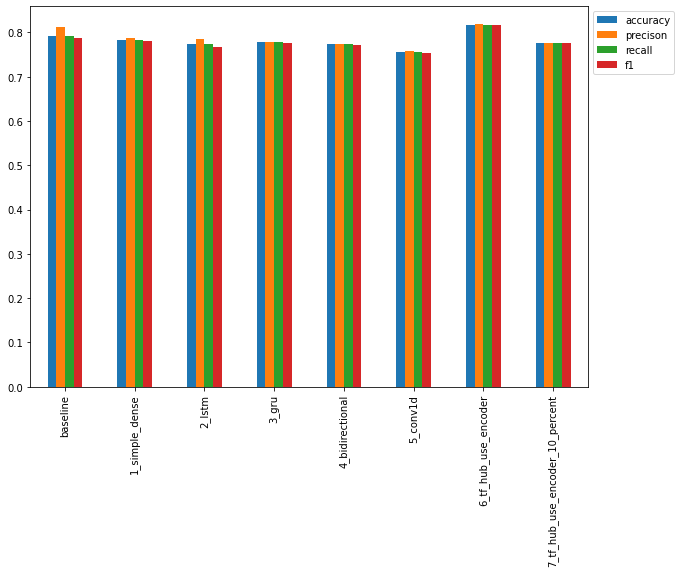

In [107]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

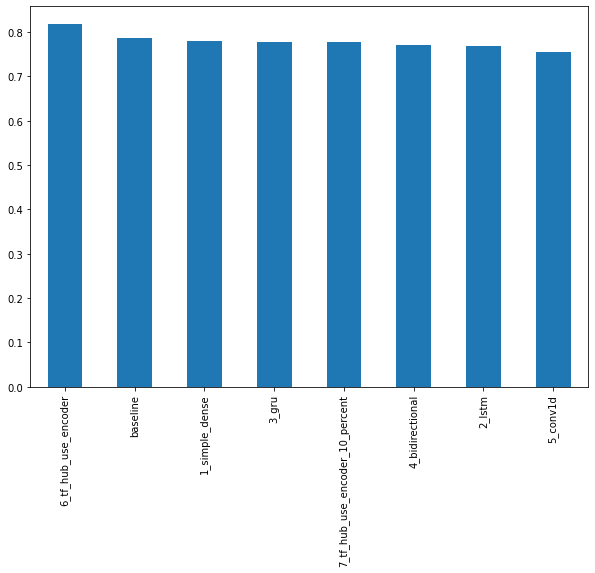

In [108]:
# Sort model results by f1-socre
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind='bar', figsize=(10,7));

In [109]:
# EXercise

## Uploading our model training logs to TensorBoard.dev
# !tensorboard dev upload --logdir model_logs\
#      --name "Natural Language Processing"

In [110]:
# !tensorboard dev list

### Uploading our model training logs to TensorBoard.dev

We can further inspect our model' s performance using TensorBoard.dev: https://tensorboard.dev/

In [111]:
# View TensorBoard logs of transfer learning modelling experiments (plus all of our models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments ZTM TF Course Video" \
  --description "Comparing multiple different types of model architectures on tha Kaggle Tweets text classsification dataset" \
  --one_shot # exit the uploader once uploading is finished

2021-08-14 02:12:10.873329: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) no


Now I've ran the cell above, my modelling experiment are visible on TensorBoard dev: https://tensorboard.dev/experiment/477mP8r0S0q1glLJAF6Kfw/

> 📝**Resource:** TensorBoard is greate for quickly tracking experiments but for larger scale expereiment tracking optins, check out Weights & Biases: https://wand.ai/site

In [112]:
# # See the previous TensoBoard Dev experiments you've run..
# !tensorboard dev list

In [113]:
# # If you need to delete an experiment from TensorBoard, you can run the following:
# !tensorboard dev delete --experiment_id xgdsgaesfadaweg

In [114]:
## Exericse
model_6.save("best_performing_model.h5")

## Saving and Loading a trained model

There are two main formats to save model to in TensorFlow:
1. The HDF5 format
2. The `SavedMOdel` format (this is the default when using TensorFlow)

In [115]:
# Save TF Hub sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [116]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [117]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4289 - accuracy: 0.8176


[0.42893290519714355, 0.817585289478302]

Exercise : Read Documentation in TensorFlow : https://www.tensorflow.org/tutorials/keras/save_and_load

Now let's save to the `SavedModel` format..(see more on this here:https://www.tensorflow.org/tutorials/keras/save_and_load)

In [118]:
# Save TF Hub sentences Encoder model to SavedModel format (default)
model_6.save("model_6_SavedMOdel_format")

INFO:tensorflow:Assets written to: model_6_SavedMOdel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedMOdel_format/assets


In [119]:
# Load in a modelfrom the SavedModel format.
loaded_model_6_SavedMOdel_format = tf.keras.models.load_model("model_6_SavedMOdel_format")


In [120]:
# Evaluate model in SavedModel format
loaded_model_6_SavedMOdel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4289 - accuracy: 0.8176


[0.42893290519714355, 0.817585289478302]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [121]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip

!unzip 08_model_6_USE_feature_extractor.zip

--2021-08-14 02:15:52--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  36.1MB/s    in 16s     

2021-08-14 02:16:08 (57.5 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables

In [122]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [123]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [124]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})

val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [125]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positive

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


Let's remind ourselves of the target labels...
* 0 = not disaster
* 1 = disaster

In [126]:
most_wrong.tail() # these are false negative

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [127]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-----

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

-----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

-----

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

-----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!


In [128]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

-----

Target: 1, Pred: 0.0, Prob: 0.055075809359550476
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

-----

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

-----

Target: 1, Pred: 0.0, Prob: 0.054596975445747375
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

-----

Target: 1, Pred: 0.0, Prob: 0.049637261778116226
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

-----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

-----

Target: 1, Pred: 0.0, 

## Making predictions on the test dataset

In [131]:
# Making predictions on the test dataset and visualizing them 
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences, 10)
for test_samples in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_samples])) # our model expects as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_samples}\n")
  print("---\n")

Pred: 1, Prob: 0.6952428221702576
Text:
Refugees as citizens - The Hindu http://t.co/GJSaAf3U6K

---

Pred: 0, Prob: 0.2506030797958374
Text:
Next up: a charity program for disadvantaged people displaced by the tech boom in SF based on Tinder technology.  https://t.co/yNVz1WrgtN

---

Pred: 1, Prob: 0.8823904395103455
Text:
New warning for Central Hills 1' hail 60 mph winds. NOT affecting Sturgis but could later tonight. #KOTAWeather http://t.co/E8oUxVKuTE

---

Pred: 0, Prob: 0.09878772497177124
Text:
?????? FREE!!! ÛÏThis book will blow your mindÛ_Û ??????

'Suspense danger anger love and (most importantly)... http://t.co/nzN5nTPn75

---

Pred: 1, Prob: 0.5278408527374268
Text:
@davej798 @JohnEJefferson remind me when SomaliaEritrea &amp; Nigeria were bombed by UK 28% of asylum applicants to UK 2014 were from S &amp; E

---

Pred: 0, Prob: 0.47166600823402405
Text:
Fotoset: ÛÏYou are the person who survived a bunch of rainstorms and kept walking. I now believe that pain... http:

### Your challenge...predictiong on Tweets from the wild

Go to your favourite Twitter account and Copy one of their latest Tweets.

Then pass that Tweet through our trained model

Is that Tweet a disaster or not disaster( according to the model)? Is the model right or wrong?

In [134]:
tweet = "Draft number 5 of my first novel finished and printed.It’s called Charlie Walks.And it’s about a machine learning engineer who wants to be a writer.These words are very close to what’ll be in the final version.Coming soon."
model_pred_probs = tf.squeeze(model_6_pretrained.predict([tweet]))
model_preds = tf.round(model_pred_probs)
print(f"Pred: {int(model_preds)}, Prob: {model_pred_probs}")
print("---\n")

Pred: 0, Prob: 0.06341584771871567
---



In [138]:
tweet= 'when you fix a tensor shape issue'
model_pred_probs = tf.squeeze(model_6_pretrained.predict([tweet]))
model_preds = tf.round(model_preds_probs)
print(f"Pred: {int(model_preds)}, prob:{model_pred_probs}")

Pred: 0, prob:0.09635080397129059


In [137]:
tweet = "Found a YouTube channel dedicated to raising a pet seagull.Great alternative to college"
model_pred_probs = tf.squeeze(model_6_pretrained.predict([tweet]))
model_preds = tf.round(model_preds_probs)
print(f"Pred: {int(model_preds)}, prob:{model_pred_probs}")

Pred: 0, prob:0.03306401148438454


In [142]:
def tweet_disaster(tweets, model):
  model_preds_probs = tf.squeeze(model.predict([tweets]))
  model_preds = tf.round(model_preds_probs)
  print(f"Prediction: {int(model_preds)}, Prediction_Probabilities: {model_preds_probs}")


tweet_1 = "Neeraj Chopra of #IND takes #gold in the #Athletics men’s javelin final on his Olympic debut!"
tweet = tweet_disaster(tweets=tweet_1, model=model_6_pretrained)

tweet_2 = ""

Prediction: 0, Prediction_Probabilities: 0.11184557527303696


## The speed/score tradeoff

In [143]:
# Let's make a function to measure the time of prediction 
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  """

  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time # Calculate how long predictions took to make predictions
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [145]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                           samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.22265197500018985, 0.00029219419291363495)

In [146]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.017391057000168075, 2.282290944903947e-05)

In [151]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                       y_pred = model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'f1': 0.8148082644367335,
 'precison': 0.818446310697231,
 'recall': 0.8162729658792651}

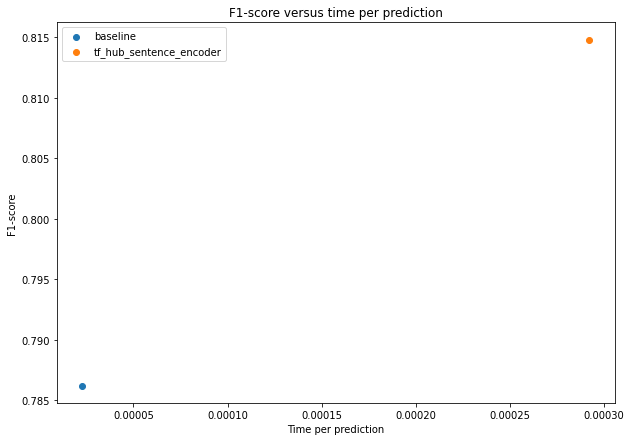

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");